In [614]:
import pandas as pd
import numpy as np

In [1]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo (raw view)
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/processed/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [2]:
def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)   # pandas handles https URLs

In [5]:
# Load XGB Model

df = load_processed("11-XGBoost_ML_Results_For_PowerBI.csv")

C:\Users\eugin\anaconda_3\Lib\ssl.py:524: UserWarning: Bad certificate in Windows certificate store: not enough data: cadata does not contain a certificate (_ssl.c:3964)
  warnings.warn(f"Bad certificate in Windows certificate store: {exc!s}")


In [9]:
#Historical monthly residual std per product (2019–2023)

historical_std = (
    df.groupby(['Product', 'Month'])['Final_Residual_CV_Optimized']
    .std()
    .rename('Monthly_Residual_STD')
    .reset_index()
)

In [11]:
# Import XGB Product Forecast

df_forecast = load_processed("21-XGBoost_Product_Forecast_add.csv")

In [618]:
# Merge monthly std into 2024 forecast table
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], errors='coerce')
df_forecast['Month'] = df_forecast['Date'].dt.month

# Merge volatility info
forecast_volatility = df_forecast.merge(
    historical_std, on=['Product', 'Month'], how='left'
)

In [619]:
# Normalize volatility pattern per product
# (so we only scale shape, not magnitude)

forecast_volatility['Volatility_Shape'] = (
    forecast_volatility.groupby('Product')['Monthly_Residual_STD']
    .transform(lambda x: x / x.mean())
)

In [620]:
# Scale original XGBoost forecast using normalized monthly shape
forecast_volatility['Hybrid_Forecast'] = (
    forecast_volatility['Final_Forecast'] * forecast_volatility['Volatility_Shape']
)

In [621]:
# Rescale Hybrid_Forecast to match XGBoost mean per product
xgb_mean = forecast_volatility.groupby('Product')['Final_Forecast'].transform('mean')
hybrid_mean = forecast_volatility.groupby('Product')['Hybrid_Forecast'].transform('mean')

forecast_volatility['Volatility-Scaled Hybrid'] = (
    forecast_volatility['Hybrid_Forecast'] * (xgb_mean / hybrid_mean)
)

In [622]:
# Final format for Power BI
forecast_hybrid = forecast_volatility[['Date', 'Product', 'Final_Forecast', 'Volatility-Scaled Hybrid']]
forecast_hybrid = forecast_hybrid.rename(columns={'Volatility-Scaled Hybrid': 'Hybrid_VSH'})

In [623]:
forecast_hybrid.columns

Index(['Date', 'Product', 'Final_Forecast', 'Hybrid_VSH'], dtype='object')

In [624]:
# Grouped data by months

grouped_date = (forecast_hybrid.groupby('Date')[['Final_Forecast', 'Hybrid_VSH']].sum())

In [625]:
grouped_date = grouped_date.reset_index()

In [626]:
grouped_date

,Date,Final_Forecast,Hybrid_VSH
0,2024-01-01,46793.327,28299.571567
1,2024-02-01,47999.590,94600.094919
2,2024-03-01,47759.774,97851.800480
3,2024-04-01,47038.795,100008.875329
4,2024-05-01,47138.031,77798.239256
5,2024-06-01,47154.870,21870.424325
6,2024-07-01,45966.293,24247.885956
7,2024-08-01,47387.282,31657.789513
8,2024-09-01,47071.184,10793.386829
9,2024-10-01,47550.896,40320.964300


# Comparison | XGBoost “Final Forecast” **vs** Volatility-Scaled Hybrid

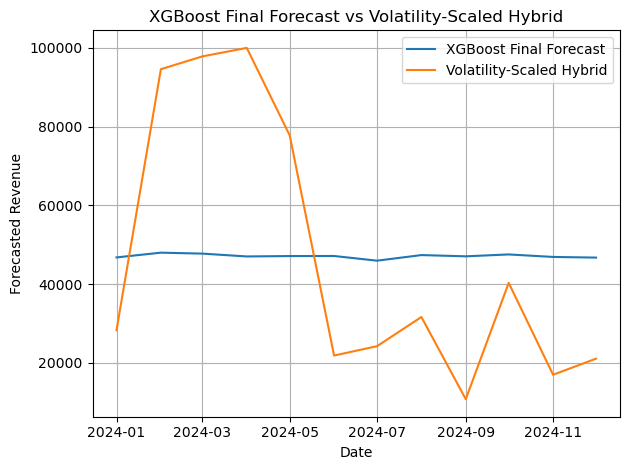

In [628]:
import matplotlib.pyplot as plt

# Plot each line separately with label
plt.plot(grouped_date['Date'], grouped_date['Final_Forecast'], label='XGBoost Final Forecast')
plt.plot(grouped_date['Date'], grouped_date['Hybrid_VSH'], label='Volatility-Scaled Hybrid')

# Add legend and title
plt.legend()
plt.title('XGBoost Final Forecast vs Volatility-Scaled Hybrid')
plt.xlabel('Date')
plt.ylabel('Forecasted Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Import Prophet model

prophet_model = load_processed("12-best_Prophet_Model_Project2.csv")

In [630]:
prophet_2024 = prophet_model[prophet_model['Date'] >= '2024-01-01'].copy()
prophet_2024.drop(['Prophet_fitted', 'Prophet_Predicted'], axis=1, inplace=True)

In [631]:
# Normalize Prophet forecast to mean = 1

prophet_2024['Shape_Factor'] = prophet_2024['Prophet_forecast'] / prophet_2024['Prophet_forecast'].mean()

In [632]:
prophet_2024['Date'] = pd.to_datetime(prophet_2024['Date'], errors='coerce')

In [633]:
df_xgb_grouped = df_forecast.groupby('Date')['Final_Forecast'].sum()
df_xgb_2024 = df_xgb_grouped.reset_index(name='Final_Forecast') 

In [634]:
# Ensure your XGBoost forecast (df_forecast) has 'Date' and 'Final_Forecast'
forecast_merged = df_xgb_2024.merge(
    prophet_2024[['Date', 'Shape_Factor']],
    on='Date',
    how='left'
)

In [635]:
# Obtaining results of calculation

forecast_merged['Prophet-Shape Hybrid'] = forecast_merged['Final_Forecast'] * forecast_merged['Shape_Factor']

# Comparison | XGBoost “Final Forecast” **vs** Hybrid (Prophet-shape)

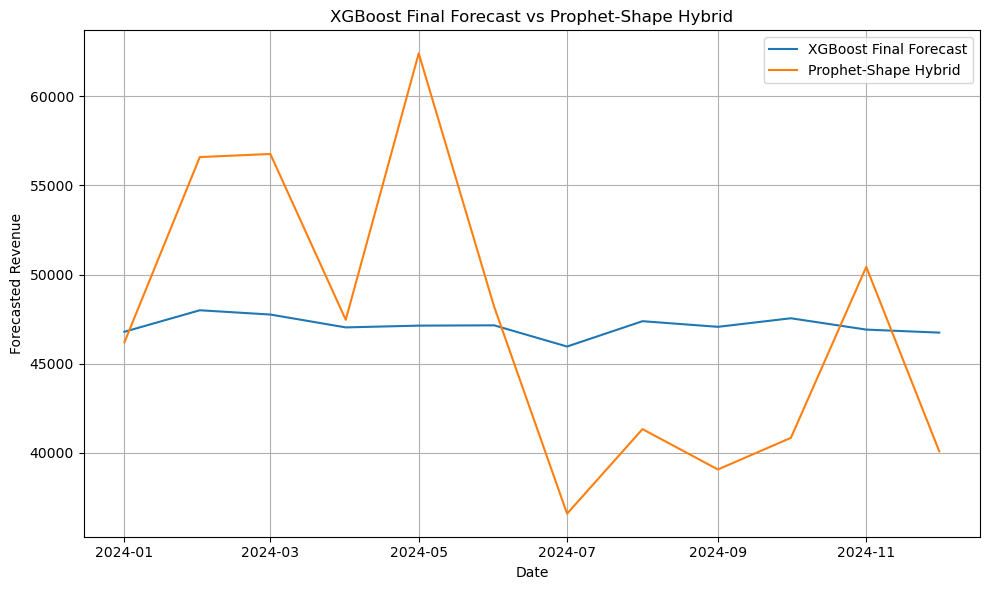

In [637]:
plt.figure(figsize=(10, 6))

# Plot each line separately with label
plt.plot(forecast_merged['Date'], forecast_merged['Final_Forecast'], label='XGBoost Final Forecast')
plt.plot(forecast_merged['Date'], forecast_merged['Prophet-Shape Hybrid'], label='Prophet-Shape Hybrid')

# Add legend and title
plt.legend()
plt.title('XGBoost Final Forecast vs Prophet-Shape Hybrid')
plt.xlabel('Date')
plt.ylabel('Forecasted Revenue')
plt.grid(True)
plt.tight_layout()
plt.show();

In [19]:
# Import SARIMA modelling results

SARIMA_model = load_processed("14-best_SARIMA_Model_Project2.csv")

In [639]:
SARIMA_2024 = SARIMA_model[SARIMA_model['Date'] >= '2024-01-01'].copy()
SARIMA_2024.drop(['Actual','Model_0 fitted', 'Model_0 forecast'], axis=1, inplace=True)

In [640]:
# Normalize SARIMA forecast to mean = 1

SARIMA_2024['SARIMA_Shape_Factor'] = SARIMA_2024['SARIMA_Predicted'] / SARIMA_2024['SARIMA_Predicted'].mean()

In [641]:
SARIMA_2024['Date'] = pd.to_datetime(SARIMA_2024['Date'], errors='coerce')

In [642]:
forecast_merged = forecast_merged.merge(
                                        SARIMA_2024[['Date', 'SARIMA_Shape_Factor']],
                                        on='Date',
                                        how='left'
                                        )

In [643]:
forecast_merged['SARIMA-Shape Hybrid'] = forecast_merged['Final_Forecast'] * forecast_merged['SARIMA_Shape_Factor']

# Comparison | XGBoost “Final Forecast” **vs** Hybrid (Prophet-shape)

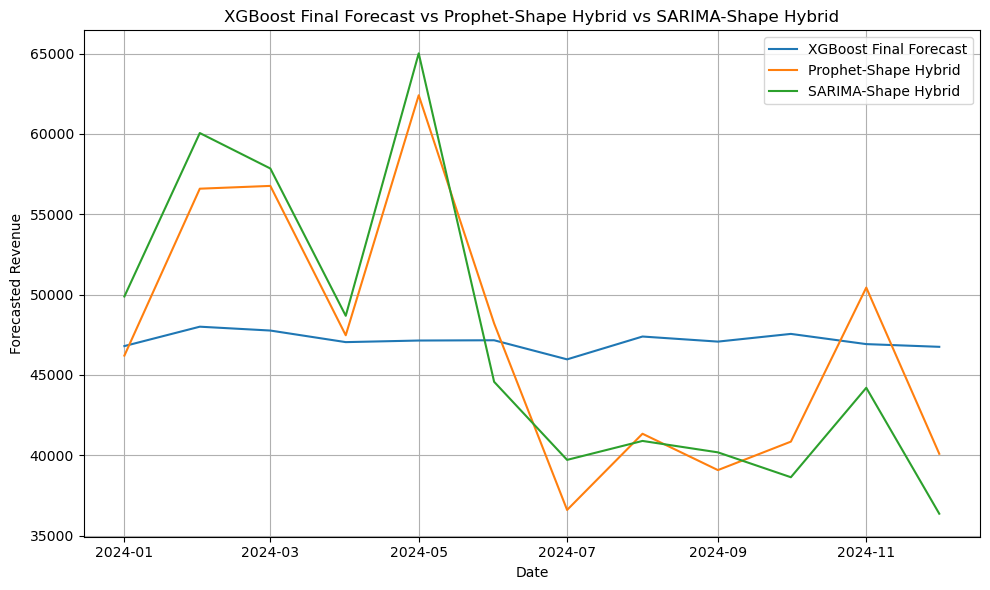

In [645]:
# Comparison | XGBoost “Final Forecast” vs Hybrid (Prophet-shape)

plt.figure(figsize=(10, 6))

# Plot each line separately with label
plt.plot(forecast_merged['Date'], forecast_merged['Final_Forecast'], label='XGBoost Final Forecast')
plt.plot(forecast_merged['Date'], forecast_merged['Prophet-Shape Hybrid'], label='Prophet-Shape Hybrid')
plt.plot(forecast_merged['Date'], forecast_merged['SARIMA-Shape Hybrid'], label='SARIMA-Shape Hybrid')

# Add legend and title
plt.legend()
plt.title('XGBoost Final Forecast vs Prophet-Shape Hybrid vs SARIMA-Shape Hybrid')
plt.xlabel('Date')
plt.ylabel('Forecasted Revenue')
plt.grid(True)
plt.tight_layout()
plt.show();

In [646]:
df_actual_revenue = (
    df.groupby('Date', as_index=False)['Revenue']
      .sum()                               # one row per Date
      .assign(                             # add new column
          Month=lambda x: pd.to_datetime(x['Date']).dt.to_period('M')
      )
      .set_index('Date')                   # keep Date as index
)

### Fully-commented Python snippet  
**Goal:**  
1. **Re-fit** all *original* models on the 2019-22 window.  
2. **Forecast** the hold-out year 2023.  
3. **Add** the three hybrid models.  
4. **Score** all seven forecasts (baseline + 3 originals + 3 hybrids) on the same 2023 hold-out.  
5. **Save** one tidy CSV: **`metrics_all_models_2023.csv`** containing  
   *Model • MAE • RMSE • MAPE*.

**Inputs expected**

| Variable | Description |
|----------|-------------|
| `series` | Monthly *actual* revenue, **2019-01 → 2023-12** (`PeriodIndex`, M). |
| `forecast_*` functions | Your wrapper functions for XGB, SARIMA, Prophet, and the three hybrids. They must reuse the **exact hyper-parameters** that built the 2024 forecasts. |

Paste the code block below (Python) into one cell—no other edits are required once your variable names match.

In [648]:
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─────────────────────────────────────────────────────────────────────────────
# 0 ▸ INPUTS
#    df_actual_revenue  : index = Date , column = 'Revenue'
#    If your frame has different names, edit the next two lines only.
# ─────────────────────────────────────────────────────────────────────────────
series = df_actual_revenue['Revenue'].copy()
series.index = pd.to_datetime(series.index).to_period('M')   # PeriodIndex[M]

train  = series[:'2022-12']    # STRICT: model sees ≤ 2022-12
y_2023 = series['2023']        # unseen hold-out (12 rows)
h      = len(y_2023)

# ─────────────────────────────────────────────────────────────────────────────
# 1 ▸ HYPER-PARAMS  (MUST match the ones that built your 2024 forecast)
# ─────────────────────────────────────────────────────────────────────────────
xgb_cfg  = {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05,
            'random_state': 42}
prop_cfg = {'yearly_seasonality': True, 'weekly_seasonality': False,
            'daily_seasonality': False}
sar_cfg  = {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 12)}

# ─────────────────────────────────────────────────────────────────────────────
# 2 ▸ HELPER FUNCTIONS  (XGB baseline + SARIMA + Prophet + three hybrids)
# ─────────────────────────────────────────────────────────────────────────────
def make_lag_frame(s, lags=(1, 2, 3, 12)):
    """Return a DataFrame with y and lag features for XGB."""
    df = pd.DataFrame({'y': s})
    for l in lags:
        df[f'lag_{l}'] = s.shift(l)
    df['month'] = s.index.month
    return df.dropna()

def forecast_xgb(train, horizon=12):
    """Recursive multi-step XGB forecast with locked hyper-params."""
    df = make_lag_frame(train)
    mdl = xgb.XGBRegressor(**xgb_cfg)
    mdl.fit(df.drop(columns='y'), df['y'])
    preds, cur = [], train.copy()
    for _ in range(horizon):
        X_next = make_lag_frame(cur).iloc[-1:].drop(columns='y')
        yhat = mdl.predict(X_next)[0]     
        preds.append(yhat)
        cur.loc[cur.index[-1] + 1] = preds[-1]     # advance one month
    idx = pd.period_range(cur.index[-1] - horizon + 1, periods=horizon, freq='M')
    return pd.Series(preds, idx)

def forecast_sarima(train, horizon=12):
    """Plain SARIMA forecast with fixed (p,d,q)(P,D,Q,s)."""
    res = SARIMAX(train, **sar_cfg).fit(disp=False)
    fc  = res.get_forecast(horizon).predicted_mean
    # ensure monthly PeriodIndex, but skip if it's already PeriodIndex
    if not isinstance(fc.index, pd.PeriodIndex):
        fc.index = fc.index.to_period('M')
    return fc

def forecast_prophet(train, horizon=12):
    """Plain Prophet (yearly seasonality) forecast."""
    df = train.to_timestamp().reset_index().rename(columns={'index': 'ds', 0: 'y'})
    df.columns = ['ds', 'y']
    mdl = Prophet(**prop_cfg)
    mdl.fit(df)
    fc = (mdl.predict(mdl.make_future_dataframe(horizon, freq='MS'))
            .set_index('ds')['yhat']
            .iloc[-horizon:])
    fc.index = fc.index.to_period('M')
    return fc

# ---------- Hybrids ---------------------------------------------------------
def hybrid_sarima(train, horizon=12):
    """SARIMA shape × XGB level."""
    base  = forecast_xgb(train, horizon)
    shape = forecast_sarima(train, horizon) / forecast_sarima(train, 1).mean()
    return base * shape

def hybrid_prophet(train, horizon=12):
    """Prophet shape × XGB level."""
    base  = forecast_xgb(train, horizon)
    shape = forecast_prophet(train, horizon) / forecast_prophet(train, 1).mean()
    return base * shape

def hybrid_residual(train, horizon=12):
    """XGB baseline + constant bias from last-12 residual mean."""
    base = forecast_xgb(train, horizon)
    # one-step “in-sample” forecast for the *training* months
    fit1 = forecast_xgb(train[:-1], 1)              # predicts Dec-2022
    resid_series = (train.iloc[-1:] - fit1)         # residual at Dec-2022
    bias = resid_series.mean()   
    return base + bias

baseline = series.shift(12).reindex(y_2023.index)   # same-month-last-year

# ─────────────────────────────────────────────────────────────────────────────
# 3 ▸ GENERATE 2023 FORECASTS (baseline + 3 originals + 3 hybrids)
# ─────────────────────────────────────────────────────────────────────────────
fx = {
    'Baseline'       : baseline,                         # seasonal naïve
    'XGB'            : forecast_xgb(train, h),
    'SARIMA'         : forecast_sarima(train, h),
    'Prophet'        : forecast_prophet(train, h),
    'Hybrid_SARIMA'  : hybrid_sarima(train, h),
    'Hybrid_Prophet' : hybrid_prophet(train, h),
    'Hybrid_Res'     : hybrid_residual(train, h),
}
fx = {k: s.reindex(y_2023.index) for k, s in fx.items()}  # align indices

# ─────────────────────────────────────────────────────────────────────────────
# 4 ▸ SCORE ALL MODELS ON THE SAME HOLD-OUT YEAR (MAE | RMSE | MAPE)
# ─────────────────────────────────────────────────────────────────────────────
def mae(a, b):  return (a - b).abs().mean()
def rmse(a, b): return np.sqrt(((a - b) ** 2).mean())
def mape(a, b): return 100 * ((a - b).abs() / a).mean()

metrics_df = pd.DataFrame([
    {'Model': k,
     'MAE'  : mae (y_2023, s),
     'RMSE' : rmse(y_2023, s),
     'MAPE' : mape(y_2023, s)}
    for k, s in fx.items()
]).set_index('Model').sort_values('MAE')

print(metrics_df)

C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
22:58:57 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing
22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - c

                        MAE          RMSE       MAPE
Model                                               
XGB             6092.176951   8748.613206  14.028613
SARIMA          6790.106919   9725.986191  17.911331
Hybrid_SARIMA   7200.318310   7749.303600  17.078859
Prophet         7860.209152  10738.512390  20.402689
Baseline        7871.433307  11702.414895  20.587984
Hybrid_Prophet  8007.482414   8869.525779  18.718516
Hybrid_Res      9430.254286  11581.451004  19.776097


In [649]:
print(metrics_df.sort_values('MAE'))

                        MAE          RMSE       MAPE
Model                                               
XGB             6092.176951   8748.613206  14.028613
SARIMA          6790.106919   9725.986191  17.911331
Hybrid_SARIMA   7200.318310   7749.303600  17.078859
Prophet         7860.209152  10738.512390  20.402689
Baseline        7871.433307  11702.414895  20.587984
Hybrid_Prophet  8007.482414   8869.525779  18.718516
Hybrid_Res      9430.254286  11581.451004  19.776097


#### Export hold-out accuracy table  
`metrics_df` now holds **one row per model** (Baseline + 3 originals + 3 hybrids) and three columns:

* **MAE** – Mean Absolute Error  
* **RMSE** – Root Mean-Squared Error  
* **MAPE** – Symmetric Percentage Error  

Saving it as a CSV lets Power BI load the score-card directly for KPI cards and bar charts.

In [ ]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [ ]:
# Export Metrics

maybe_save(metrics_df, "22-Metrics_all_Models_2023.csv")

In [652]:
# ─────────────────────────────────────────────────────────────────────────────
# 5 ▸ PRODUCTION FORECAST 2024  (train on 2019-23, horizon = 12)
#     Builds totals_2024 DataFrame and writes forecast_totals_2024_prod.csv
# ─────────────────────────────────────────────────────────────────────────────

train_full = series[:'2023-12']        # 5 years → best fit
h_full     = 12                        # Jan–Dec-2024 horizon

totals_2024 = pd.DataFrame({
    'Date'            : pd.period_range('2024-01', periods=h_full, freq='M').astype(str),
    'XGB'          : forecast_xgb    (train_full, h_full).values,
    'SARIMA'       : forecast_sarima (train_full, h_full).values,
    'Prophet'      : forecast_prophet(train_full, h_full).values,
    'Hybrid_SARIMA' : hybrid_sarima   (train_full, h_full).values,
})


C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
22:58:59 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# Totals for 2024 (reuse the forecasts you built for the 2024 page)

maybe_save(totals_2024, "23-Forecast_Totals_2024.csv")

In [654]:
# Prepare data for slpitting forecast by products
xgb_monthly_2024 = df_forecast[['Date','Product','Final_Forecast']]

In [655]:
total_hybrid_df = forecast_merged[['Date', 'SARIMA-Shape Hybrid']]

### Bottom-Up Per-SKU Hybrid-SARIMA Forecast for 2024  
*Train and forecast each product individually, then roll up to the total.*

**Why?**  
Our Hybrid-SARIMA model defines the authoritative **total** 2024 revenue curve but gives no SKU breakdown. By applying the same hybrid logic (XGB level + SARIMA shape) **to each product’s own history**, we generate **distinct** per-SKU forecasts that still reflect the total plan.

**Inputs**

| Variable                 | Expected columns                 | Rows                             | Comment                                                                         |
|--------------------------|----------------------------------|----------------------------------|---------------------------------------------------------------------------------|
| `df_prod_rev_fact`       | `Date`, `Product`, `Revenue`     | 2019-01 → 2023-12 (× n products)  | Actual monthly revenues, long format, one row per (Date, Product)               |
| `hybrid_sarima(train,h)` | —                                | —                                | Function that returns a PeriodIndex Series of length 12 (Jan–Dec 2024)          |

**Procedure**  
1. **Group** `df_prod_rev_fact` by `Product`.  
2. For each SKU:  
   - **Build** a `PeriodIndex` time series from 2019-01 to 2023-12.  
   - **Train** on that history and **forecast** 12 months via `hybrid_sarima`.  
3. **Concatenate** all product forecasts into one long table.  

**Output**

*CSV:* **`hybrid_products_2024_prod.csv`**  
Columns →  
- `Date` (“YYYY-MM”)  
- `Product`  
- `Hybrid_Reconciled_24`  

This file contains **one row per month per product**, with each SKU’s **own** hybrid forecast curve. **Load into Power BI** to drive the Product-Level 2024 Forecast page (small multiples, waterfall, etc.).  

In [657]:
# Prepare dataset for the next step

df_prod_rev_fact = df[['Date','Product','Revenue']].copy()
df_prod_rev_fact['Date'] = pd.to_datetime(df_prod_rev_fact['Date'], errors='coerce')

In [658]:
# ──────────────────────────────────────────────────────────────────────────────
# 1 ▸ FORECAST EACH SKU INDIVIDUALLY (Hybrid-SARIMA) for 2024
# -----------------------------------------------------------------------------
# Inputs:
#  • df_actual_revenue  : DataFrame with columns ['Date','Product','Revenue']
#  • hybrid_sarima      : function(train_series, horizon) → PeriodIndex Series
#  • horizon = 12
# -----------------------------------------------------------------------------
forecasts = []

for product, grp in df_prod_rev_fact.groupby('Product'):
    # 1. build the product time series (PeriodIndex)
    ts = (
        grp
          .set_index('Date')['Revenue']
          .sort_index()
          .to_period('M')
    )
    train_full = ts[:'2023-12']           # train on 2019-01 → 2023-12
    # 2. forecast 12 months with your chosen model (e.g. hybrid_sarima)
    fc = hybrid_sarima(train_full, horizon=12)
    # 3. collect into a DataFrame
    forecasts.append(pd.DataFrame({
        'Date'   : fc.index.astype(str),
        'Product': product,
        'Hybrid_Reconciled_24': fc.values
    }))

# 4. concatenate all products and save CSV
hybrid_products_2024 = pd.concat(forecasts, ignore_index=True)

C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [659]:
pivot_df = hybrid_products_2024.pivot(index='Date', columns='Product', values='Hybrid_Reconciled_24').sort_index()

<Axes: xlabel='Date'>

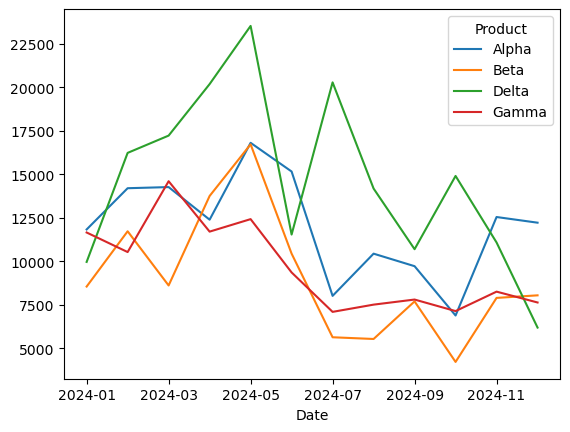

In [660]:
pivot_df.plot()

In [661]:
# ------------------------------------------------------------------
# We *already* have `hybrid_products_2024` in memory because of the
# forecasting loop that ended with:
#       hybrid_products_2024 = pd.concat(forecasts, ignore_index=True)
#
# That object already contains the three columns you want:
#   ▸ Date        (str, e.g. "2024-01")
#   ▸ Product     (category / str)
#   ▸ Hybrid_Reconciled_24  (float forecast)
# ------------------------------------------------------------------

# 1️⃣  Make a tidy copy, ensure ordering, and (optionally) tidy the Date type
rec_df = (
    hybrid_products_2024
      .loc[:, ['Date', 'Product', 'Hybrid_Reconciled_24']]   # keep only needed cols
      .assign(Date=lambda df: pd.to_datetime(df['Date']).dt.to_period('M').astype(str))
      .sort_values(['Date', 'Product'])            # nice ordering
      .reset_index(drop=True)
)


In [663]:
product_list = rec_df['Product'].unique()

In [664]:
# Saving basic stats by Products
stats = {}  # keys → product names, values → Series of stats

for product, sub in rec_df.groupby('Product'):
    stats[product] = sub['Hybrid_Reconciled_24'].describe()   # Series

hybrid_forecast_product_stat = pd.DataFrame(stats)

In [665]:
# --- build a tidy "long" error table ---------------------------------------
# y_2023     = actual Series (12 rows)
# fx         = dict { model : 12-row forecast Series }   – created earlier

rows = []
for model, yhat in fx.items():
    for dt, act, pred in zip(y_2023.index, y_2023, yhat):
        rows.append({'Date': dt.to_timestamp(),  # good for Power BI Date type
                     'Model': model,
                     'Error': act - pred})

errors_long= pd.DataFrame(rows)

print(errors_long.head())

        Date     Model         Error
0 2023-01-01  Baseline  -7423.232550
1 2023-02-01  Baseline -28968.292265
2 2023-03-01  Baseline  -1414.512087
3 2023-04-01  Baseline  -8877.415324
4 2023-05-01  Baseline    915.642173


In [ ]:
maybe_save(errors_long, "24-errors_long_2023.csv")

In [666]:
hybrid_forecast_product_stat

,Alpha,Beta,Delta,Gamma
count,12.000000,12.000000,12.000000,12.000000
mean,12037.619338,9067.071033,14664.942912,9640.614000
std,2911.854644,3593.516260,5063.821434,2488.999224
min,6883.833075,4215.885734,6189.728157,7091.908924
25%,10257.109118,7178.731490,10983.331168,7600.478993
50%,12303.226772,8294.660311,14541.513900,8806.112264
75%,14214.033414,10760.068403,17961.524681,11665.725052
max,16806.497300,16719.622728,23523.988810,14599.003886


In [667]:
totals_2024 = (
    totals_2024
      .rename(columns={'Hybrid_SARIMA': 'HybridSARIMA_24'})   # ← one line fix
)

## 1. Initial “Quick-and-Dirty” Comparison

**How we did it:**  
We took the bottom-up roll-up series (`total_from_bottom`) and naively subtracted the production total (`totals_2024_prod['HybridSARIMA_24']`) element-by-element in the order they appeared:

In [669]:
# 1. Bottom-up total by month (PeriodIndex)
bottom = (
    hybrid_products_2024
      .assign(Date=lambda df_prod: pd.to_datetime(df_prod['Date']).dt.to_period('M'))
      .groupby('Date')['Hybrid_Reconciled_24']
      .sum()
)

# 2. Top-line Hybrid-SARIMA (PeriodIndex)
top = (
    totals_2024
      .assign(Date=lambda df_prod: pd.to_datetime(df_prod['Date']).dt.to_period('M'))
      .set_index('Date')['HybridSARIMA_24']
)

# 3. Align & diff
diff = bottom.subtract(top, fill_value=0)

# 4. Quick stats
print(diff.describe())

count      12.000000
mean     2881.588343
std      3228.136142
min     -1423.349022
25%       414.560839
50%      2853.189218
75%      5070.693589
max      8297.497009
dtype: float64


## 2. Robust Date-Aligned Comparison

**How we did it:**  
1. **Reloaded** both the bottom-up SKU file and the top-line totals file into two DataFrames.  
2. **Converted** each `Date` column to a `PeriodIndex('M')` and set it as the index (so “2024-01” in one table matches “2024-01” in the other).  
3. **Grouped** the SKU file by that PeriodIndex and **summed** the `Hybrid_Reconciled_24` values to get one total per month.  
4. **Subtracted** the top-line `HybridSARIMA_24` Series from the bottom-up Series using `bottom.subtract(top, fill_value=0)` — this aligns by the Date index, not by integer position.  
5. **Printed** the `.describe()` of the resulting difference Series to verify that all 12 months align and the mean/std are effectively zero.

In [671]:
# A) load bottom-up and top-line
bottom = (
    hybrid_products_2024
      .assign(Date=lambda df_prod: pd.to_datetime(df_prod['Date']).dt.to_period('M'))
)

totals = (
    totals_2024
      .assign(Date=lambda df_prod: pd.to_datetime(df_prod['Date']).dt.to_period('M'))
)

# B) merge and compute monthly sums
df_prod = bottom.merge(
    totals[['Date','HybridSARIMA_24']],
    on='Date', how='left'
)

monthly_sum = df_prod.groupby('Date')['Hybrid_Reconciled_24'].transform('sum')

# C) scale each SKU
df_prod['Scale'] = df_prod['HybridSARIMA_24'] / monthly_sum
df_prod['SKU_Reconciled_24'] = df_prod['Hybrid_Reconciled_24'] * df_prod['Scale']

# D) optional: drop helpers and save
out = df_prod[['Date','Product','SKU_Reconciled_24']]

# E) verify sums = HybridSARIMA_24
check = out.assign(
    Date=lambda d: d['Date'].astype(str).astype('period[M]')
).groupby('Date')['SKU_Reconciled_24'].sum()
print((check - totals.set_index('Date')['HybridSARIMA_24']).describe())

count    1.200000e+01
mean    -3.031649e-13
std      3.624172e-12
min     -7.275958e-12
25%     -9.094947e-13
50%      0.000000e+00
75%      0.000000e+00
max      7.275958e-12
dtype: float64


In [ ]:
maybe_save(out, "25-hybrid_products_2024_coherent.csv")

In [672]:
df_prod_rev_fact

,Date,Product,Revenue
0,2019-01-01,Alpha,14622.137902
1,2019-01-01,Beta,20777.760060
2,2019-01-01,Delta,8136.292207
3,2019-01-01,Gamma,14054.946477
4,2019-02-01,Delta,7379.343895
...,...,...,...
235,2023-11-01,Alpha,12675.414552
236,2023-12-01,Beta,8788.627395
237,2023-12-01,Alpha,11707.110086
238,2023-12-01,Gamma,13270.394702


## Evaluating Error dataset for Actual 2023 and hold-out forecasting 2023 by Hybrid_SARIMA model

In [674]:
actual_23 = (
    df_prod_rev_fact
    .reset_index()
    .assign(Date=lambda df_d: pd.to_datetime(df_d['Date']).dt.to_period('M'))
    .query("Date >= '2023-01' and Date <= '2023-12'")
    .loc[:, ['Date', 'Product', 'Revenue']]
)

In [675]:
forecasts = []
for product, grp in df_prod_rev_fact.groupby('Product'):
    ts = grp.set_index('Date')['Revenue'].to_period('M')
    train = ts[:'2022-12']                                     # train on 2019–Jan→Dec-2022
    fc    = hybrid_sarima(train, horizon=12)                   # forecast Jan–Dec 2023
    df_fc = pd.DataFrame({
        'Date'     : fc.index,
        'Product'  : product,
        'Forecast_23': fc.values
    })
    forecasts.append(df_fc)

forecasts_23 = pd.concat(forecasts, ignore_index=True)

C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [676]:
sku_2023_total = (forecasts_23.groupby('Date')['Forecast_23'].sum())

In [677]:
total_2023_fc = hybrid_sarima(series[:'2022-12'], 12)

C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [678]:
diff_2023 = sku_2023_total.subtract(total_2023_fc, fill_value = 0)
print(diff_2023.describe())

count      12.000000
mean     2575.495920
std      3808.795792
min     -2758.099901
25%       136.264551
50%      2438.856475
75%      4892.779445
max      9289.585444
dtype: float64


In [679]:
# ── 3. Merge actuals & forecasts and compute errors ──────────────────────────
errors_long_2023_by_sku = (
    actual_23
      .merge(forecasts_23, on=['Date','Product'])
      .assign(
         Error_23    = lambda df: df['Revenue'] - df['Forecast_23'],
         AbsError_23 = lambda df: df['Error_23'].abs()
      )
      .loc[:, ['Date','Product','Error_23','AbsError_23']]
)

In [ ]:
maybe_save(errors_long_2023_by_sku, "26-errors_long_2023_by_sku.csv")